In [2]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
#import seaborn as sb

In [3]:
workdir='/home/f0042vb/CHEM101.6/week1/'
datadir='/home/f0042vb/CHEM101.6/week1/data/'
outdir='/home/f0042vb/CHEM101.6/week1/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/home/f0042vb/CHEM101.6/week1/data/butane.pdb
/home/f0042vb/CHEM101.6/week1/data/butane.gaff2.xml


In [ ]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

In [3]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x7f830915bed0>

In [5]:
atoms, bonds = traj.topology.to_dataframe()
#Lets select the topology
top=traj.topology
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


In [46]:
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [6]:
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])

Line Parameters: [0.50013159 0.07697498]


/tmp/ipykernel_26364/1769237437.py:9: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


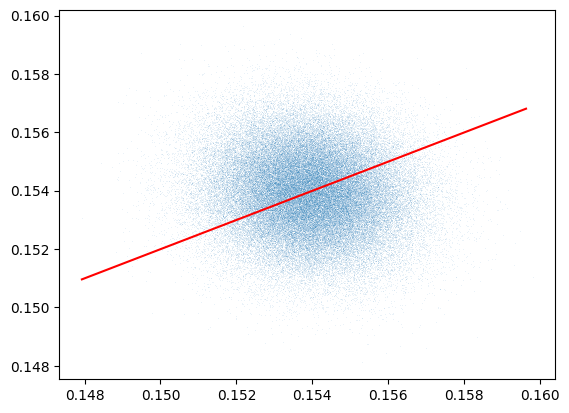

/tmp/ipykernel_26364/1769237437.py:22: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


r2: -0.0981774557999295
Line Parameters: [0.49996995 0.07695011]


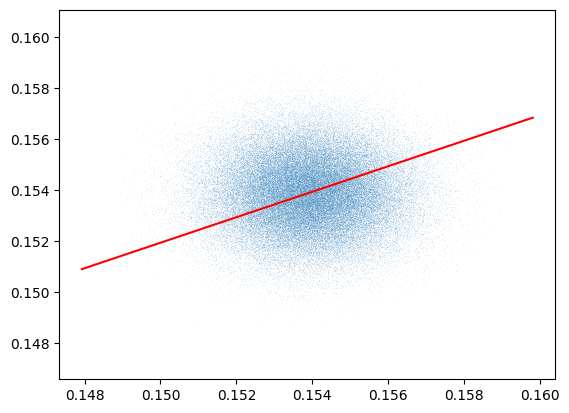

r2: 0.003909745850723504


In [7]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

Answer:

C1-C2 and C2-C3 bonds are more correlated compared to C1-C2 & C3_C4. This is because C1-C2 and C2-C3 bond pair is directly adjacent, so that their movements are more synchronized due to torsional stain and rotational barrier, while C1-C2 & C3-C4 bonds are separated by another bond.


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Function:0.03457436090151178 * exp(-(x-0.15389988680972647)^2/(2*0.0013704219575777087^2)
Function:0.033295449653685937 * exp(-(x-0.15394986774394928)^2/(2*0.0013806794662680453^2)
Function:0.03818331679708716 * exp(-(x-0.15390066336237462)^2/(2*0.0013775271251307089^2)


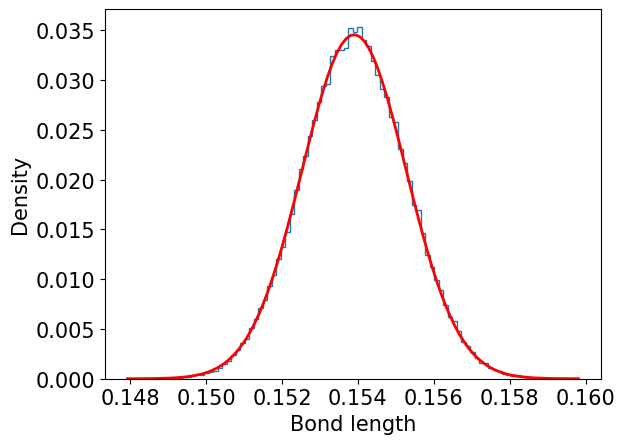

In [9]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
from scipy.optimize import curve_fit

def normal_distribution(x, a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

# The following function will give a fit function, and give a plot if the parameter plot set to be True.

def plot_gaussian(data, *args, plot = False, bin_number = 100):
    counts,edges = np.histogram(data,bins=bin_number)
    centers = edges[:-1] + np.diff(edges)/2
    distance = edges[1]-edges[0]
    initial_guess = [1,np.mean(data),np.std(data)]
    popt, pcov = curve_fit(normal_distribution, centers,counts/(len(data)),maxfev=5000,p0=initial_guess)
    
    if plot:
        x = np.linspace(max(data),min(data),100)
        p = normal_distribution(x,*popt)

        plt.plot(x,p,'r-',lw=2)
        plt.stairs(counts/(len(data)),edges)
        plt.xlabel(args[0], size=15)
        plt.xticks(size=15)
        plt.ylabel(args[1], size=15)
        plt.yticks(size=15)
        plt.show()
    
    return centers, counts/(len(data)), popt

# Print functions
data_list = [C1C2bondlength,C2C3bondlength,C3C4bondlength]

for data in data_list:

    centers, density, popt = plot_gaussian(data)
    print("Function:{0} * exp(-(x-{1})^2/(2*{2}^2)".format(*popt))


#Plot Example
    
centers, density, popt = plot_gaussian(C1C2bondlength, "Bond length", "Density" ,plot=True)



**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

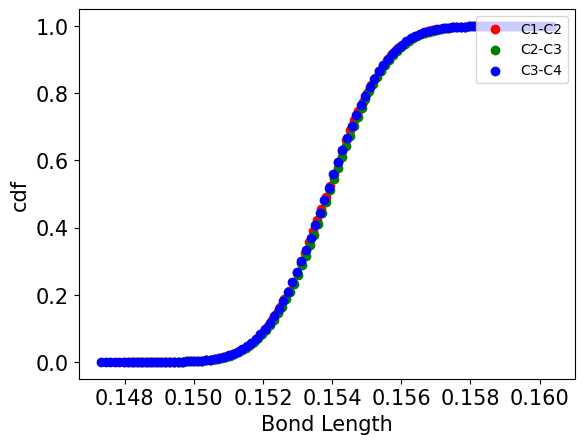

In [10]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####


#ADD CODE FOR CDFs HERE#
def cdf(data):
    counts,edges = np.histogram(data,bins=100)
    centers = edges[:-1] + np.diff(edges)/2

    total = len(data)
    current_count = 0
    cdf = []

    for this_count in counts:
        current_count += this_count
        cdf.append(current_count/total)
     
    return centers, np.array(cdf)


cdf_list = list(map(cdf,data_list))
colors = ["r","g","b"]
names = ["C1-C2","C2-C3","C3-C4"]

for i, cdf_results in enumerate(cdf_list):
    plt.scatter(*cdf_results,label=names[i],color=colors[i])

plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('cdf', size=15)
plt.yticks(size=15)
plt.show()    

**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1. A Bond Angle 2. A Dihedral Angle ***

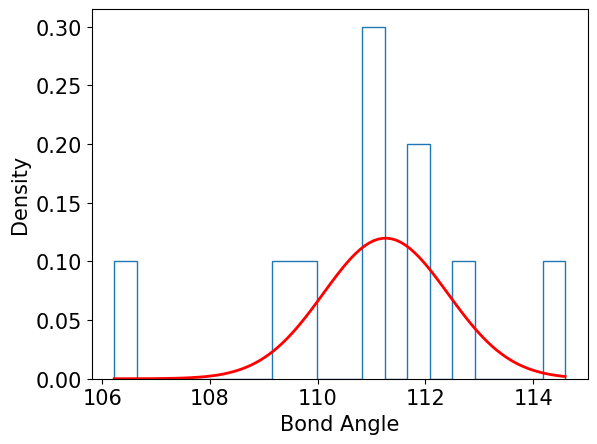

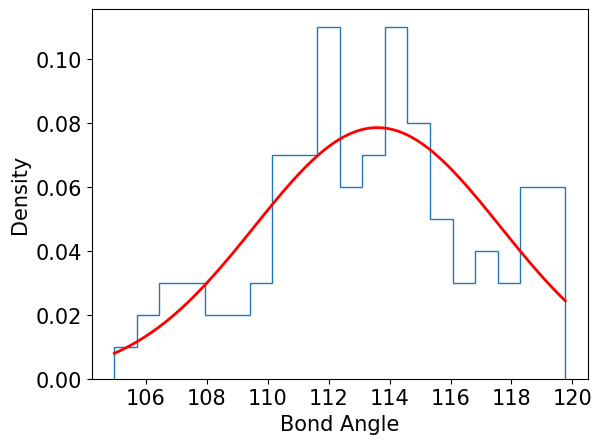

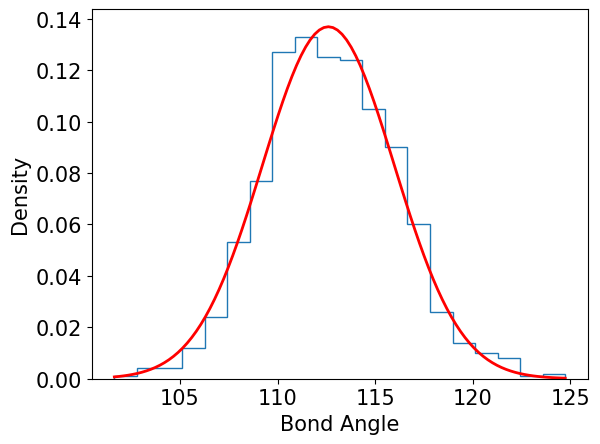

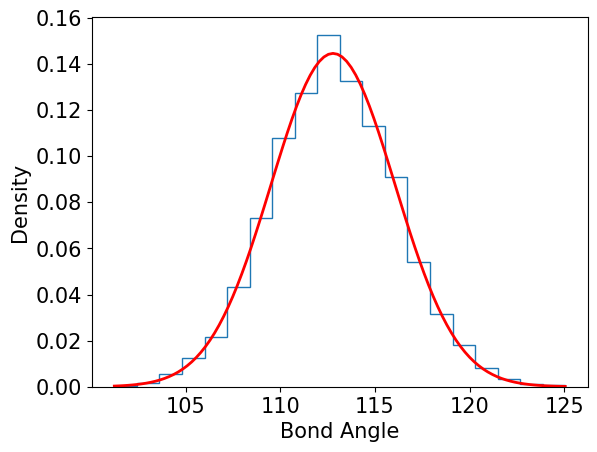

In [16]:
# Bond angle 
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])



for sample in [10,100,1000,10000]:
    rands = np.random.randint(10000, size=(sample))
    plot_gaussian(ang[:,0][rands]/np.pi*180, "Bond Angle", "Density", plot=True, bin_number=20)


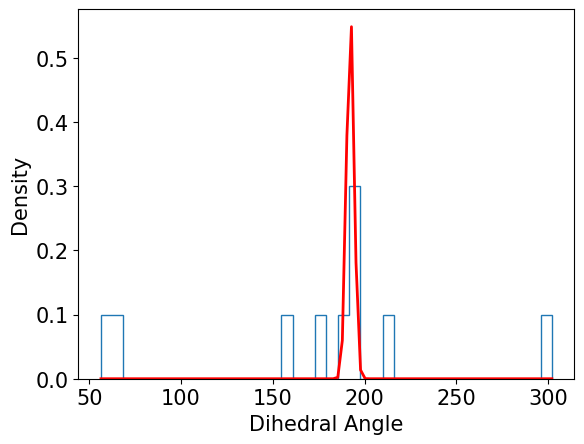

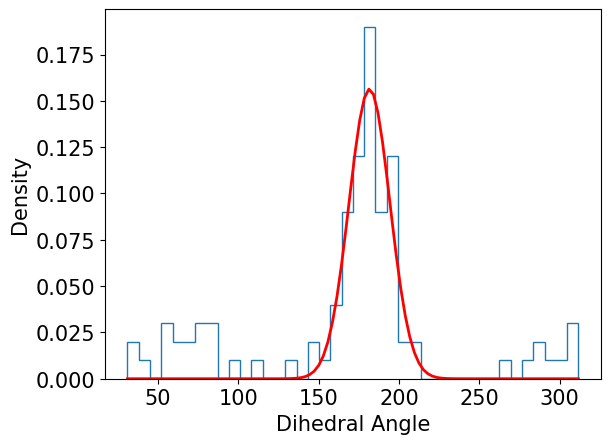

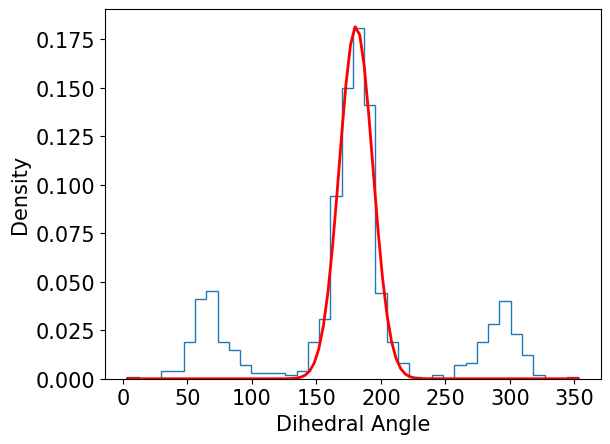

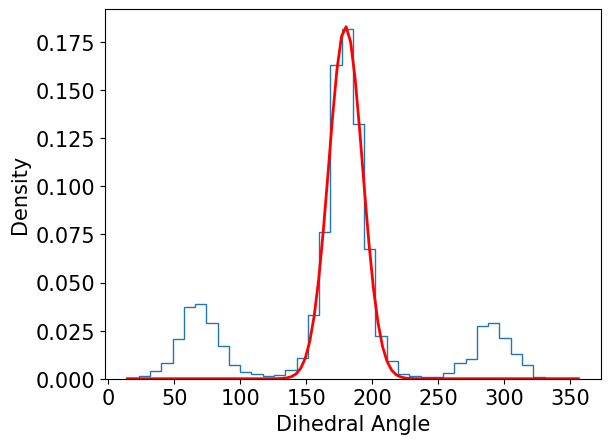

In [20]:


#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?
def shift(angle):
    return angle if angle >0 else angle +2* np.pi

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

shift_torsion = np.array(list(map(shift,CCCC_torsion)))

# centers, density, popt  = plot_gaussian(shift_torsion/np.pi*180, "Bond Angle", "Density", plot=True, bin_number=100)

for sample in [10,100,1000,10000]:
    rands = np.random.randint(10000, size=(sample))
    plot_gaussian(shift_torsion[rands]/np.pi*180, "Dihedral Angle", "Density", plot=True, bin_number=40)

# According to the law of large numbers, only when the sample number is large enough can the data distribution converge to the true distribution.

**Homework Problem #3: What is the probability of being found in the higher free energy C-C-C-C dihedral states?**

In [44]:
converted_tortions = np.abs(CCCC_torsion).flatten()


is_high_energy_state = (converted_tortions<2) & (converted_tortions>0.5)

probability = float(is_high_energy_state.mean())

print("The probability of being found in the higher energy dihetral states is {:.1f}%.".format(probability*100))

The probability of being found in the higher energy dihetral states is 21.0%.


**Homework Problem #4: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

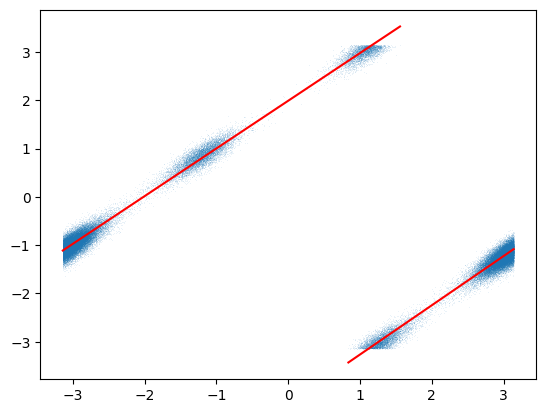

r2: 0.9941 and 0.9772
Offset: 114.00˚ and -245.37˚


In [72]:
# Select two torsions that are correlated
torsion_index_1 = [0,4,7,10]
torsion_index_2 = [6,4,7,8]
torsion_1=md.compute_dihedrals(traj, [torsion_index_1]).flatten()
torsion_2=md.compute_dihedrals(traj, [torsion_index_2]).flatten()


plt.scatter(torsion_1,torsion_2,marker='x',s=0.1,linewidth=0.05)

# From the plot we can see two correlated regions, now we select two regions by offset and get the correlation functions between them.

region_1 = []
region_2 = []
for first_torsion, second_torsion in zip(torsion_1,torsion_2):
    if  np.abs(first_torsion-second_torsion)/np.pi < 1:
        region_1.append([first_torsion,second_torsion])
    else:
        region_2.append([first_torsion,second_torsion])

region_1 = np.array(region_1)
region_2 = np.array(region_2)

def fit(data):
    line_fit=np.polyfit(data[:,0],data[:,1],1)
    x = np.linspace(min(data[:,0]), max(data[:,0]),20)
    y = line_fit[0]*x+line_fit[1]
    r=np.corrcoef(data[:,0],data[:,1])
    return line_fit, x, y, r


popt1,x1,y1,r1 = fit(region_1)
popt2,x2,y2,r2 = fit(region_2)

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='r')

plt.show()
print("r2: {0:.4f} and {1:.4f}".format(r1[0,1],r2[0,1]))
print("Offset: {0:.2f}˚ and {1:.2f}˚".format(np.rad2deg(popt1[1]),np.rad2deg(popt2[1])))


The offset was calculated to be ~120˚ and ~ -240˚. This is because these two torsions are along the same bonds, and are 120˚ away from each other from a Newman projection. 

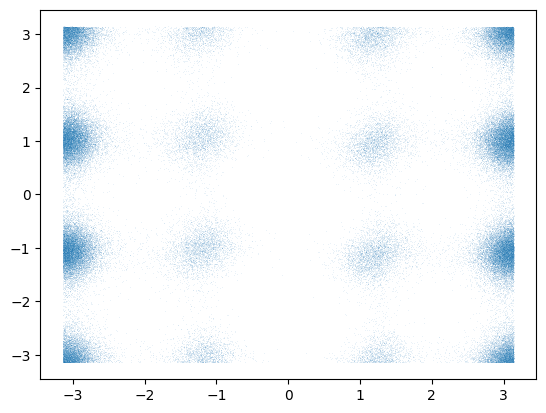

In [76]:
# Now select two torsions that are not correlated
torsion_index_1 = [0,4,7,10]
torsion_index_3 = [1,0,4,5]
torsion_1=md.compute_dihedrals(traj, [torsion_index_1]).flatten()
torsion_3=md.compute_dihedrals(traj, [torsion_index_3]).flatten()


plt.scatter(torsion_1,torsion_3,marker='x',s=0.1,linewidth=0.05)
plt.show()

The diagram illustrates several distinct areas, attributable to the fact that torsional angles predominantly assume values of either ±180˚ or ±120˚. Consequently, the data points primarily cluster within these intersecting zones. Moreover, the secondary torsional angle, situated at the molecule's terminus, results in negligible energy disparities between the ±180˚ and ±120˚ positions. This absence of variation is reflected along the y-axis, whereas along the x-axis, the regions associated with ±180˚ (indicative of lower energy) exhibit greater density compared to those at ±120˚ (indicative of higher energy). Overall, there appears to be a lack of significant correlation between these two torsional angles, given their localization to distinct bonds within the molecule.

**WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential**


To accurately represent a specific target shape—considering a Gaussian as an example—we can employ Fourier series. Given that the torsion energy function is an even function with a period of $2\pi$, it's suitable to utilize the Fourier cosine series for this purpose. The Fourier cosine series is expressed as:

$F(\phi) = \frac{1}{2}a_0 + \sum_{n=1}^{\infty}a_n \cos\left(\frac{n\pi x}{L}\right)$

where

- $a_0 = \frac{2}{L} \int_{0}^{L}f(x)\,dx$
- $a_n = \frac{2}{L} \int_{0}^{L}f(x) \cos(nx)\,dx$

In the context of periodic torsion energy, the function is formulated as:

$E(\phi) = \sum_{i=1}^{n}k_i(1+\cos(p\phi - \phi_0))$

By aligning the Fourier series with this torsion energy function, we observe that by setting $k_i = a_i$ and $\phi_i = 0$, the two functions can mirror each other's shape. It’s important to note, however, that this alignment introduces an offset, which represents one of the method's limitations.

To compute the coefficients, we can use the symbolic computation package `sympy` in Python. It is worth noting that by configuring the Gaussian function to exhibit symmetry around $\phi = \pi$, the coefficients corresponding to odd terms, denoted by $a_{2n+1}$, will equal zero. Consequently, we can extend the series up to the 12th term while exclusively incorporating even terms into our functions.


In [72]:

import sympy as sp



# Define the Gaussian torsion potential function
N = 6

x, L, n = sp.symbols('x L n', real=True)
f = 3 * sp.exp(-((x - sp.pi)**2) / 0.25)

L_value = 2*np.pi  



a_n = 2/L * sp.integrate(f * sp.cos(n * sp.pi * x / L), (x, 0, L))

a_n_substituted = a_n.subs(L, L_value)
coefficients = []

for n_value in range(2,2*(N+1),2):


    a_n_numerical = a_n_substituted.subs(n, n_value).evalf()
    
    coefficients.append(a_n_numerical)    



# Assuming the period is 2pi, calculate k1-6, phase1-6 (always 0 for cos terms), periodicity1-6

k_values = coefficients[::]  
phases = [0] * N  # Phase shifts are 0 for pure cosine terms
periodicities = list(range(1,N+1))  # Periodicities from 1 to 6

# Print the values
for i in range(6):
    print(f"k{i+1}: {k_values[i]}, phase{i+1}: {phases[i]}, periodicity{i+1}: {periodicities[i]}")




k1: -0.795010597032086, phase1: 0, periodicity1: 1
k2: 0.659086934201584, phase2: 0, periodicity2: 2
k3: -0.482198301896406, phase3: 0, periodicity3: 3
k4: 0.311330623065446, phase4: 0, periodicity4: 4
k5: -0.177390841835468, phase5: 0, periodicity5: 5
k6: 0.0891977169177220, phase6: 0, periodicity6: 6


In [146]:
# Generate format for the xml file

def generate_xml(k_values, phases, periodicities):    

    xml_base = '<Proper class1="c3" class2="c3" class3="c3" class4="c3"'
    
  
    torsion_attributes = []
    for i, (k, phase, periodicity) in enumerate(zip(k_values, phases, periodicities), start=1):
        torsion_attributes.append(f' periodicity{i}="{periodicity}" phase{i}="{phase}" k{i}="{k}"')
    

    xml_complete = xml_base + ''.join(torsion_attributes) + '/>'
    
    return xml_complete

print(generate_xml(k_values, phases, periodicities))

<Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="1" phase1="0" k1="-0.795010597032086" periodicity2="2" phase2="0" k2="0.659086934201584" periodicity3="3" phase3="0" k3="-0.482198301896406" periodicity4="4" phase4="0" k4="0.311330623065446" periodicity5="5" phase5="0" k5="-0.177390841835468" periodicity6="6" phase6="0" k6="0.0891977169177220"/>


Before running the simulation, we can plot the torsion energy and the gaussian to compare them with each other. To illustrate this more clearly, we calculate the offset (This offset will not be included in the real simulation). From the plot one can see that they are very similar to each other.

In [73]:
a_0 = 2/L * sp.integrate(f , (x, 0, L))
a_0_substituted = a_0.subs(L, L_value)
a_0_value = a_0_substituted.evalf()

offset = 1/2 *a_0_value - sum(k_values)

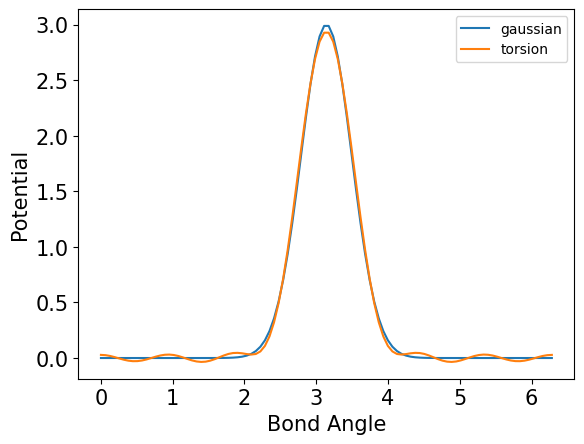

In [75]:

def gaussian_torsion(x, k, s):
    return k * np.exp(-((x - np.pi)**2) / s)



def torsion_terms(x, ks,phase_values,periodicity_values):
    total = 0
    for k,phase,periodicity in zip(ks,phase_values,periodicity_values):
        total += k*(1+np.cos(periodicity*x+phase))
    
    return total

x = np.linspace(0,2*np.pi,100)
gaussian = gaussian_torsion(x,3,0.25)
simulated_gaussian = torsion_terms(x,k_values,phases,periodicities)


plt.plot(x,gaussian,label = "gaussian")
plt.plot(x,offset+simulated_gaussian,label = "torsion")
plt.legend(loc='upper right')
plt.xlabel('Bond Angle', size=15)
plt.xticks(size=15)
plt.ylabel('Potential', size=15)
plt.yticks(size=15)
plt.show()

To see whether the potential works, we can first run a simulation with 0 torsion potential to get a "base-line" fpr dihedral distribution (now the torsions are mainly driven by 1-4 interactions). By adjusting all ks to be 0, we can cancel all the torsion interactions.

In [60]:
forcefield_file_name = datadir+'butane.gaff2_zero.xml'
forcefield = mm.app.ForceField(forcefield_file_name)
system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim_zero.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

import mdtraj as md
traj_zero = md.load(os.path.join(workdir, "butane_sim_zero.dcd"), top=PDB_file_name)



Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,40.301027851420564,480.7318843431546
2000,51.91314342414229,272.90477337984083
Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,35.06605701680614,240.43562681503596,0
500000,999.9999999901769,28.69472393896084,381.6204827918188,4.52e+04
750000,1499.9999999783536,58.22674677872597,310.9307056054649,4.42e+04
1000000,1999.9999999665301,33.676596330676155,238.36077185780812,4.46e+04
1250000,2499.9999999547067,45.633195917137144,229.72340902253933,4.49e+04
1500000,2999.9999999428833,31.390422188118713,285.67607093566846,4.47e+04
1750000,3499.99999993106,57.143479647111505,242.47093388859196,4.48e+04
2000000,3999.9999999192364,34.057009562718335,271.2589950194341,4.49e+04
2250000,4499.9999999992715,46.3143743370605,303.2666384144274,4.5e+04
2500000,5000.000000101135,26.043769646105055,283.3721354526004,4.51e+04
2750000,5500.00000020299

In [61]:
import mdtraj as md
traj_zero = md.load(os.path.join(workdir, "butane_sim_zero.dcd"), top=PDB_file_name)

def shift(angle):
    return angle if angle >0 else angle +2* np.pi

CCCC_index=[0,4,7,10]
CCCC_torsion_zero=md.compute_dihedrals(traj_zero, [CCCC_index])

shift_torsion_zero = np.array(list(map(shift,CCCC_torsion_zero)))
counts_zero,edges = np.histogram(shift_torsion_zero,bins=200)
centers_zero = edges[:-1] + np.diff(edges)/2

Now we can run a simulation with our modified potential.

In [62]:
forcefield_file_name = datadir+'butane.gaff2_modified.xml'
forcefield = mm.app.ForceField(forcefield_file_name)
system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim_modified.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,39.10791471537884,431.19577592675574
2000,23.671642061793833,210.08040076456547
Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,53.71579964906432,251.81634710371137,0
500000,999.9999999901769,34.03751923848006,271.05448686710605,4.11e+04
750000,1499.9999999783536,35.9627730490155,270.57012912524874,4.11e+04
1000000,1999.9999999665301,23.171435041763857,322.8336574387076,4.11e+04
1250000,2499.9999999547067,29.455391066894073,344.11330925338086,4.11e+04
1500000,2999.9999999428833,27.842852982029875,195.75778640090704,4.11e+04
1750000,3499.99999993106,38.87644315135189,186.0494077198133,4.1e+04
2000000,3999.9999999192364,41.37105976139492,408.61490754047276,4.1e+04
2250000,4499.9999999992715,26.161827758831993,283.6676730503842,4.11e+04
2500000,5000.000000101135,28.457567157231665,317.6059947158114,4.11e+04
2750000,5500.00000020299

In [63]:
import mdtraj as md
traj_2 = md.load(os.path.join(workdir, "butane_sim_modified.dcd"), top=PDB_file_name)

def shift(angle):
    return angle if angle >0 else angle +2* np.pi

CCCC_index=[0,4,7,10]
CCCC_torsion_modified=md.compute_dihedrals(traj_2, [CCCC_index])

shift_torsion_modified = np.array(list(map(shift,CCCC_torsion_modified)))
counts2,edges = np.histogram(shift_torsion_modified,bins=200)
centers2 = edges[:-1] + np.diff(edges)/2

To see difference, we can calculate the PMF difference between two simulation, which is given by:

$U - U_{0} = -\frac{1}{\beta} ln(\frac{p(\phi)}{p_{0}(\phi)}) $

where the $p(\phi) $ and $p_{0}(\phi)$ are the probability distribution of $\phi$. According to simulation parameter, $\frac{1}{\beta}$ was calculated as $\frac{298.15}{150}\approx2$

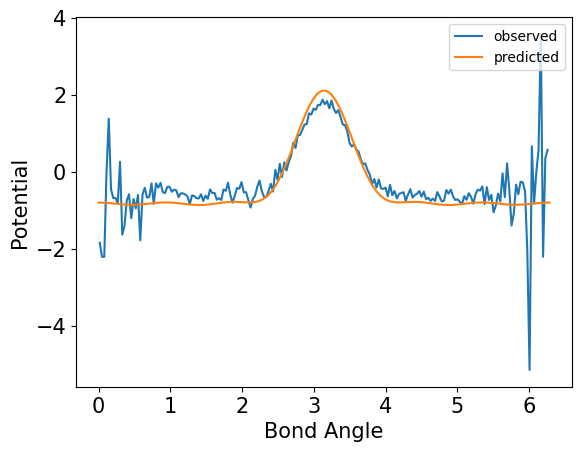

In [77]:
plt.plot(centers2,-2*np.log(counts2/counts_zero),label = "observed")
plt.plot(x,simulated_gaussian,label = "predicted")
plt.legend(loc='upper right')
plt.xlabel('Bond Angle', size=15)
plt.xticks(size=15)
plt.ylabel('Potential', size=15)
plt.yticks(size=15)
plt.show()

The predicted result matched the observed value from the trajectory. Notably the $\phi = 0 \ or\  2\pi$ regions are poorly sampled so the statistics are bad.

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

The Coulombic energy constant is better to be converted into a simulation unit, with nm, Z, and $kT$:

$E(r) = \frac{1}{4\pi\epsilon_{0}}\frac{q_{1}q_{2}}{r} = k_{e}\frac{Z_{1}Z_{2}}{r}$

thus

$k_{e} = \frac{1}{4\pi\epsilon_{0}}\frac{e^{2}}{10^{-9}} \cdot \frac{1}{298.15 \ k_{b}} = 56.04594$ 

In [20]:
# Extract the parameters:
parameters_dict = {
    0: {'charge': -0.0932, 'sigma': 0.339771, 'epsilon': 0.4510352},
    1: {'charge': -0.0814, 'sigma': 0.339771, 'epsilon': 0.4510352},
    2: {'charge': 0.0324, 'sigma': 0.2600177, 'epsilon': 0.0870272},
    3: {'charge': 0.0387, 'sigma': 0.2600177, 'epsilon': 0.0870272}
}

one_four_parameter = {"charge": 0.833333, "LJ": 0.5}

k_e = 56.04594

def L_J_intreaction(r,type_1,type_2,one_four = False):
    sigma = (parameters_dict[type_1]['sigma'] + parameters_dict[type_2]['sigma'])/2
    epsilon = np.sqrt(parameters_dict[type_1]['epsilon']*parameters_dict[type_2]['epsilon'])

    pot = 4*epsilon*((sigma/r)**12-(sigma/r)**6)

    if one_four:
        pot *= one_four_parameter["LJ"]

    return pot



def Coulomb_interaction(r,type_1,type_2,one_four = False):
    pot = k_e * (parameters_dict[type_1]['charge']*parameters_dict[type_2]['charge'])/r

    if one_four:
        pot *= one_four_parameter["charge"]

    return pot



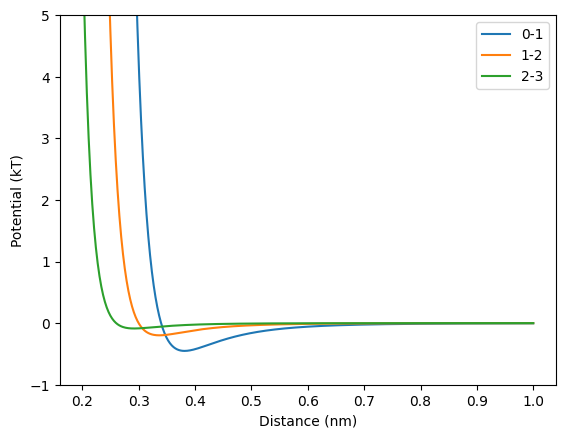

In [17]:

# Plot LJ potential

pairs = [[0,1],[1,2],[2,3]]

r = np.linspace(0.2,1,500)
# Plot the LJ potential from 0.05 nm to 0.5 nm
for pair in pairs:
    pot = L_J_intreaction(r,pair[0],pair[1])
    plt.plot(r,pot,label = f"{pair[0]}-{pair[1]}")

plt.ylim(-1, 5)
plt.xlabel("Distance (nm)")
plt.ylabel("Potential (kT)")
plt.legend(loc='upper right')
plt.show()


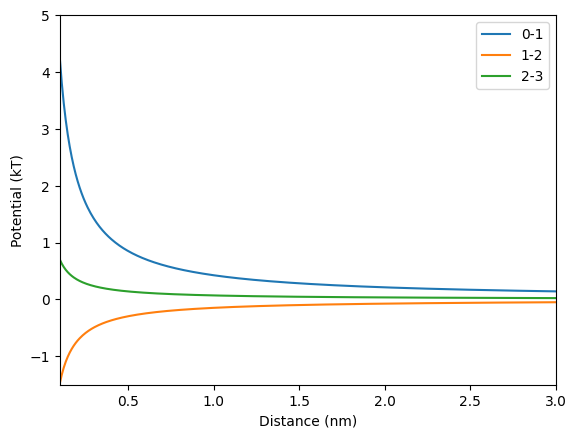

In [33]:
# Plot Coulombic potential
r_coulombic = np.linspace(0.1,3,500)
for pair in pairs:
    pot = Coulomb_interaction(r_coulombic,pair[0],pair[1])
    plt.plot(r_coulombic,pot,label = f"{pair[0]}-{pair[1]}")

plt.ylim(-1.5, 5)
plt.xlim(0.1, 3)
plt.xlabel("Distance (nm)")
plt.ylabel("Potential (kT)")
plt.legend(loc='upper right')
plt.show()
